# Exploring SVM in binary classification task

In [99]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import svm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve, auc

# Loading the data


In [100]:
training1 = pd.read_csv('training1.csv')
training2 = pd.read_csv('training2.csv')
test_data = pd.read_csv('test.csv')
sample_preds = pd.read_csv('sample_valid_predictions.csv')

print(training1.shape, training2.shape, test_data.shape)

(500, 2306) (2500, 2306) (1000, 2304)


# Data pre-processing
deal with missing data
seperate features from class labels
feature scaling
splitting dataset

In [101]:
# combine training 1 and 2 
training1_and2 = pd.concat([training1, training2], axis=0, ignore_index=True)
# Impute the mean for missing values
training3 = training1_and2.copy()
training3 = training3.fillna(training3.mean())
training3.head()


,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,...,GIST.248,GIST.249,GIST.250,GIST.251,GIST.252,GIST.253,GIST.254,GIST.255,label,confidence
0,0.00000,0.0000,0.00000,0.00000,0.38041,0.0000,0.00000,0.34408,0.00000,0.000000,...,0.002636,0.010530,0.019534,0.007312,0.006031,0.012279,0.008195,0.001981,1.0,1.00
1,0.18344,0.2521,0.00000,0.92204,0.00000,0.0000,0.50573,0.00000,0.00000,0.000000,...,0.009092,0.023169,0.033257,0.025895,0.012712,0.022264,0.013579,0.006766,0.0,0.66
2,0.00000,0.0000,0.90988,0.00000,0.00000,1.6351,0.00000,0.00000,0.00000,0.000000,...,0.042372,0.048475,0.058971,0.035549,0.031402,0.032597,0.042116,0.043504,1.0,0.66
3,1.41250,0.0000,0.00000,0.00000,0.00000,0.0000,0.42192,0.00000,0.10667,0.022025,...,0.025496,0.011774,0.012197,0.021022,0.004930,0.027289,0.026245,0.018755,0.0,0.66
4,0.00000,0.0000,0.00000,0.00000,0.99100,0.0000,0.00000,0.00000,0.31629,0.000000,...,0.012905,0.003070,0.012571,0.008038,0.010983,0.016763,0.022079,0.008992,0.0,1.00


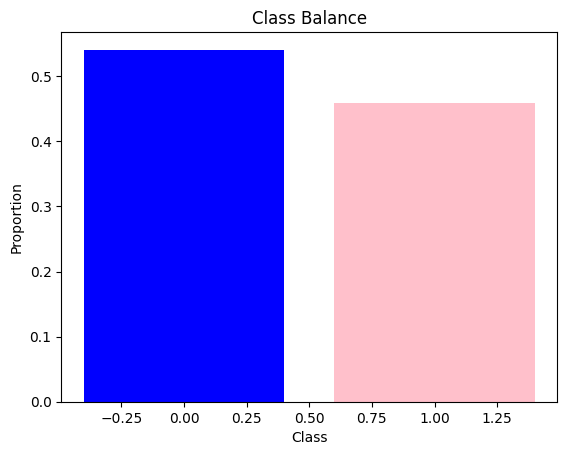

In [102]:
# Checking the class balance
class_distribution = training3['label'].value_counts(normalize=True)

plt.bar(class_distribution.index, class_distribution.values, color=['blue', 'pink'])
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Balance')
plt.show()

Feature scaling
* Normalize and standardise the feature vectors to ensure that they have similar scales. This step is important for SVMs since they are sensitive to the scale of features.

In [103]:
# standardising the data
# Scale values to have a mean of 0 and std of 1
std_scaler = StandardScaler()
train_standard = std_scaler.fit_transform(training3)
train_standard = pd.DataFrame(train_standard, index=training3.index, columns=training3.columns) # convert back to DataFrame
train_standard.shape

(3000, 2306)

In [104]:
#normalising the data
minmax_scaler = MinMaxScaler()
train_norm = minmax_scaler.fit_transform(train_standard)
train_norm = pd.DataFrame(train_norm, index=training3.index, columns=training3.columns) 

training_data = train_norm
training_data.shape

(3000, 2306)

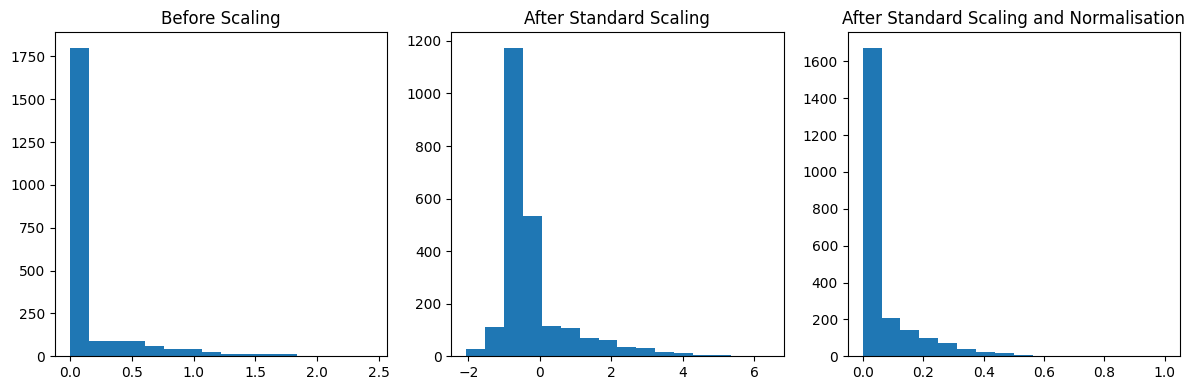

In [105]:
# Visualising the effects of feature scaling
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(training3.iloc[0], bins=16)
plt.title('Before Scaling')

# after standard scaling
plt.subplot(1, 3, 2)
plt.hist(train_standard.iloc[0], bins=16)
plt.title('After Standard Scaling')

# after normalisation
plt.subplot(1, 3, 3)
plt.hist(train_norm.iloc[0], bins=16)
plt.title('After Standard Scaling and Normalisation')

plt.tight_layout()
plt.show()

splitting dataset
* first we split the labels from the confidences
* then we split 20% of all our training data to be used as evaluation data

In [106]:
# Separate the features from the confidences in the training data
classes = training_data['label']
confidences = training_data['confidence'] 
training_data = training_data.drop(['confidence', 'label'], axis=1)

print(training_data.shape)
print(classes.shape)
print(confidences.shape)


(3000, 2304)
(3000,)
(3000,)


In [107]:
# Split the training data, features, and confidences into training and evaluation sets
train_data, eval_data, train_classes, eval_classes, train_confidences, eval_confidences = train_test_split(
    training_data, classes, confidences, test_size=0.2, random_state=42)

print("Train data shape:", train_data.shape)
print("Eval data shape:", eval_data.shape)
print("Train classes shape:", train_classes.shape)
print("Eval classes shape:", eval_classes.shape)
print("Train confidences shape:", train_confidences.shape)
print("Eval confidences shape:", eval_confidences.shape)

Train data shape: (2400, 2304)
Eval data shape: (600, 2304)
Train classes shape: (2400,)
Eval classes shape: (600,)
Train confidences shape: (2400,)
Eval confidences shape: (600,)


# SVM Model 


In [108]:
# SVM classifier with a linear kernel
linear_clf = svm.SVC(kernel='linear')

# SVM classifier with a polynomial kernel
polynomial_clf = svm.SVC(kernel='poly', degree=3) 

# Train the classifiers
linear_clf.fit(train_data, train_classes)
polynomial_clf.fit(train_data, train_classes)

# predictions on the evaluation set
linear_preds = linear_clf.predict(eval_data)
polynomial_preds = polynomial_clf.predict(eval_data)

# Model Evaluation

In [109]:
# evaluating the linear model
linear_accuracy = accuracy_score(eval_classes, linear_preds)
linear_precision = precision_score(eval_classes, linear_preds)
linear_recall = recall_score(eval_classes, linear_preds)
linear_f1 = f1_score(eval_classes, linear_preds)

# evaluating the polynomial model
polynomial_accuracy = accuracy_score(eval_classes, polynomial_preds)
polynomial_precision = precision_score(eval_classes, polynomial_preds)
polynomial_recall = recall_score(eval_classes, polynomial_preds)
polynomial_f1 = f1_score(eval_classes, polynomial_preds)

print("Linear accuracy: {}, precision: {}, recall: {}, f1: {}".format(linear_accuracy, linear_precision, linear_recall, linear_f1))
print("Polynomial accuracy: {}, precision: {}, recall: {}, f1: {}".format(polynomial_accuracy, polynomial_precision, polynomial_recall, polynomial_f1))

Linear accuracy: 0.6283333333333333, precision: 0.6174242424242424, recall: 0.5719298245614035, f1: 0.5938069216757742
Polynomial accuracy: 0.725, precision: 0.734375, recall: 0.6596491228070176, f1: 0.6950092421441775


Linear Kernel AUC: 0.6256474519632415
Polynomial Kernel AUC: 0.7218880534670008


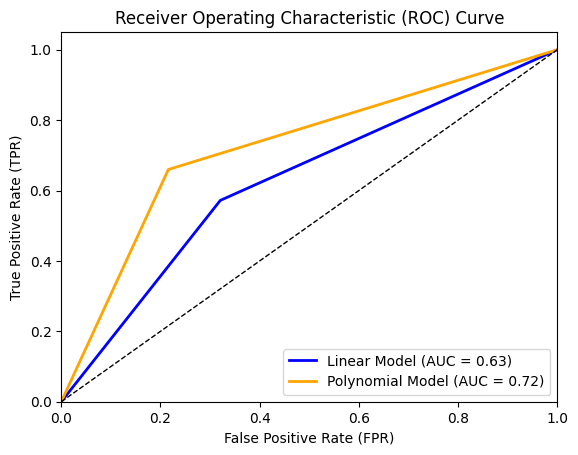

In [110]:
# finding area under the Receiver Operating Characteristic curve
# Calculate the AUC for the models
linear_auc = roc_auc_score(eval_classes, linear_preds)
print("Linear Kernel AUC:", linear_auc)
polynomial_auc = roc_auc_score(eval_classes, polynomial_preds)
print("Polynomial Kernel AUC:", polynomial_auc)

# the false positive rate and true positive rate for the linear model
linear_fpr, linear_tpr, _ = roc_curve(eval_classes, linear_preds)
linear_roc_auc = auc(linear_fpr, linear_tpr)

# FPR and TPR for the polynomial model
polynomial_fpr, polynomial_tpr, _ = roc_curve(eval_classes, polynomial_preds)
polynomial_roc_auc = auc(polynomial_fpr, polynomial_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(linear_fpr, linear_tpr, color='blue', lw=2, label='Linear Model (AUC = %0.2f)' % linear_roc_auc)
plt.plot(polynomial_fpr, polynomial_tpr, color='orange', lw=2, label='Polynomial Model (AUC = %0.2f)' % polynomial_roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Exploring methods to improve our accuracy

effect of changing hyperparameters on a few kernels

In [66]:
# we consider the effects of changing the hyperparameters
# on linear, polynomial and rbf kernels
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the hyperparameters and their possible values
param_grid = {
    'kernel': ['linear', 'polynomial', 'rbf'],  # Possible kernel types
    'C': [0.1, 1, 10],  # Possible values for C (regularization parameter)
    'gamma': [0.1, 0.01, 0.001]  # Possible values for gamma (kernel coefficient)
}

# Create an SVM classifier
svm_clf = svm.SVC()

# Create a GridSearchCV object with the SVM classifier and the hyperparameter grid
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_data, train_classes)
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_

# Train the SVM classifier with the best hyperparameters
best_svm_clf = svm.SVC(**best_params)
best_svm_clf.fit(train_data, train_classes)

# Make predictions on the evaluation set
preds = best_svm_clf.predict(eval_data)

# Calculate the accuracy of the model
accuracy = accuracy_score(eval_classes, preds)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)


C:\Users\mjswi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mjswi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mjswi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pac

                                               params  mean_test_score   
0        {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}         0.716250  \
1    {'C': 0.1, 'gamma': 0.1, 'kernel': 'polynomial'}              NaN   
2           {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}         0.544583   
3       {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}         0.716250   
4   {'C': 0.1, 'gamma': 0.01, 'kernel': 'polynomial'}              NaN   
5          {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}         0.725833   
6      {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}         0.716250   
7   {'C': 0.1, 'gamma': 0.001, 'kernel': 'polynomi...              NaN   
8         {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}         0.544583   
9          {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}         0.652083   
10     {'C': 1, 'gamma': 0.1, 'kernel': 'polynomial'}              NaN   
11            {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}         0.741250   
12        {'C': 1, 'gamma': 0.01, 'ker

Model based on these results

In [91]:
# rbf classifier with best hyperparameters
rbf_clf = svm.SVC(kernel='rbf', C=1, gamma=0.01)

rbf_clf.fit(train_data, train_classes)

new_preds = rbf_clf.predict(eval_data)

# accuracy of this model
new_accuracy = accuracy_score(eval_classes, new_preds)
new_precision = precision_score(eval_classes, new_preds)
new_recall = recall_score(eval_classes, new_preds)
new_f1 = f1_score(eval_classes, new_preds)


print("Model with radial basis function kernel, C = 1, and gamma - 0.1")
print("Accuracy: {}, Precision: {}, Recall: {}, F1: {}".format(new_accuracy, new_precision, new_recall, new_f1))

Model with radial basis function kernel, C = 1, and gamma - 0.1
Accuracy: 0.755, Precision: 0.7482014388489209, Recall: 0.7298245614035088, F1: 0.7388987566607461


trying Principal Component Analysis to improve accuracy

In [133]:
from sklearn.decomposition import PCA

# Create a PCA instance and fit the data
pca = PCA(n_components=200) 
transformed_data = pca.fit_transform(train_data)

# Use the transformed data for training your SVM model
rbf_pca_clf = svm.SVC(kernel='rbf', C=1, gamma=0.01)
rbf_pca_clf.fit(transformed_data, train_classes)

# Apply the same transformations to the evaluation data
transformed_eval_data = pca.transform(eval_data)

newest_preds = rbf_pca_clf.predict(transformed_eval_data)

# accuracy of this model
newest_accuracy = accuracy_score(eval_classes, newest_preds)
newest_precision = precision_score(eval_classes, newest_preds)
newest_recall = recall_score(eval_classes, newest_preds)
newest_f1 = f1_score(eval_classes, new_preds)

print("Accuracy: {}, Precision: {}, Recall: {}, F1: {}".format(newest_accuracy, newest_precision, newest_recall, newest_f1))

Accuracy: 0.7683333333333333, Precision: 0.7607142857142857, Recall: 0.7473684210526316, F1: 0.7388987566607461


trying weighted predictions

In [138]:
# rbf classifier with best hyperparameters
practice_clf = svm.SVC(kernel='rbf', C=1, gamma=0.01)

practice_clf.fit(train_data, train_classes)

practice_preds = practice_clf.predict(eval_data)

# array to store the weighted predictions
weighted_preds = []

for pred, confidence in zip(practice_preds, eval_confidences):
    # Assign weights based on confidence value
    weight = 1 if confidence == 1 else 0.66
    # weighted prediction
    weighted_pred = pred * weight
    weighted_preds.append(weighted_pred)

# Convert the weighted predictions to binary class labels based on a threshold
threshold = 0.65
binary_preds = [1 if pred >= threshold else 0 for pred in weighted_preds]

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(eval_classes, binary_preds)
print("Weighted Voting Accuracy:", accuracy)

Weighted Voting Accuracy: 0.755


# Final model

In [137]:
# rbf classifier with best hyperparameters
my_classifier = svm.SVC(kernel='rbf', C=1, gamma=0.01)

my_classifier.fit(train_data, train_classes)

eval_preds = rbf_clf.predict(eval_data)

# Evaluation of performance

Cross-Validation Scores: [0.73333333 0.73125    0.7625     0.75625    0.75208333]
Mean Accuracy: 0.7470833333333332
Standard Deviation: 0.012541597452743684


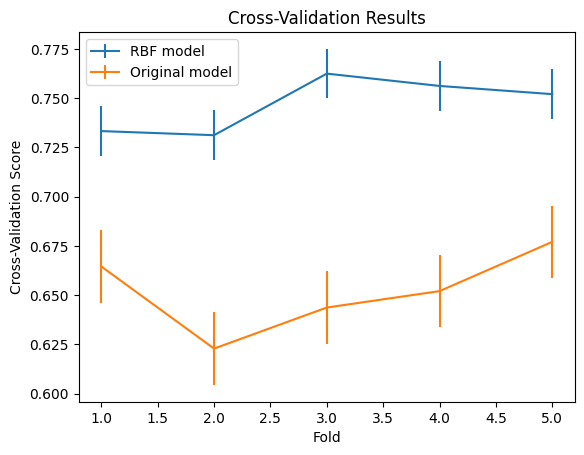

In [141]:
# cross-validation
cv_check = svm.SVC(kernel='rbf', C=1, gamma=0.01) #same parameters as my model

scores = cross_val_score(cv_check, train_data, train_classes, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())



# cross validation on our original model
linear_scores = cross_val_score(linear_clf, train_data, train_classes, cv=5)
mean_linear = np.mean(linear_scores)
std_linear = np.std(linear_scores)

# plot results
plt.figure()
plt.errorbar(range(1, 6), scores, yerr=(np.std(scores)), label='RBF model')
plt.errorbar(range(1, 6), linear_scores, yerr=std_linear, label='Original model')
plt.xlabel('Fold')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Results')
plt.legend()
plt.show()

In [113]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(eval_classes, eval_preds)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[245  70]
 [ 77 208]]


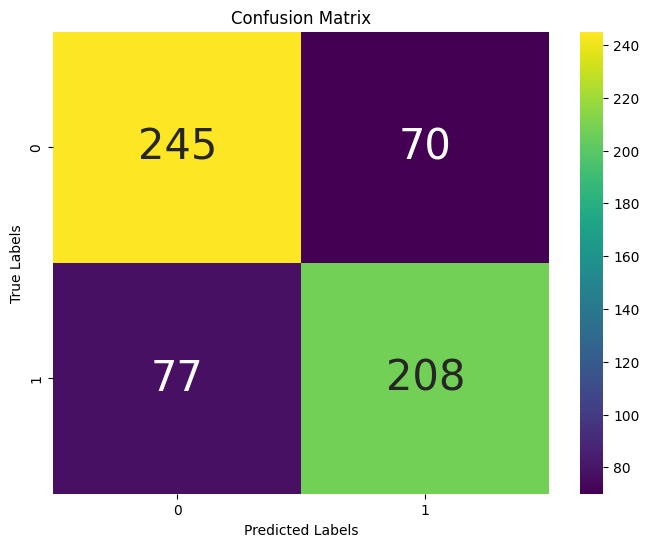

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',annot_kws={"fontsize": 30})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Predictions on test data

In [119]:
# pre process test data
test_data = test_data.fillna(test_data.mean())

# standardising the data
# Scale values to have a mean of 0 and std of 1
std_scaler = StandardScaler()
test_stand = std_scaler.fit_transform(test_data)
test_stand = pd.DataFrame(test_stand, index=test_data.index, columns=test_data.columns) # convert back to DataFrame

#normalising the data
minmax_scaler = MinMaxScaler()
test_norm = minmax_scaler.fit_transform(test_stand)
test_norm = pd.DataFrame(test_norm, index=test_data.index, columns=test_data.columns) 


test_data = test_norm
print(test_data.shape,test_norm.shape)

(1000, 2304) (1000, 2304)


In [120]:
# Make predictions on the test data
test_preds = my_classifier.predict(test_data)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(test_preds.astype(int), columns=['predictions'])

# Save predictions to CSV file
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv
